### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

## need wind speed at 10m for both UKESM and ERA5
for UKESM:
1) get daily u and v's from monthly files and save in monthly files, for all scenarios
2) regrid with cdo (u and v are on different grids and we need them on the same one to square)
3) concatenate files by year and get windspeed 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


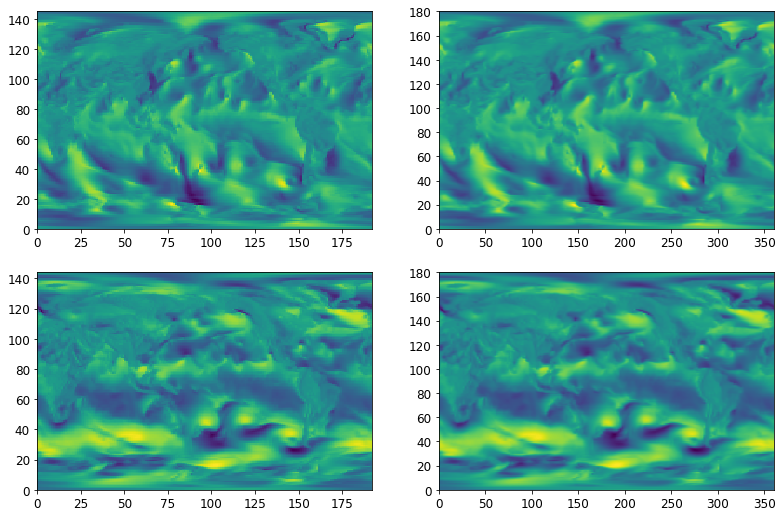

In [4]:
demo = False
tdir = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/'
if demo:
    w = xr.open_dataset('/gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/ssp126/u-be682_ssp126/be682_wind_y2070m10.nc')

    w2 = w.uwind10m.groupby('time_counter.day').mean()
    tdir = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/'
    w3 = w2.to_dataset()
    w3.to_netcdf(f'{tdir}be682_wind_y2070m10_uwind10m_daily.nc')

    w4 = w.vwind10m.groupby('time_counter.day').mean()
    w5 = w4.to_dataset()
    w5.to_netcdf(f'{tdir}be682_wind_y2070m10_vwind10m_daily.nc')

uwind_orig = xr.open_dataset(f'{tdir}be682_wind_y2070m10_uwind10m_daily.nc')
uwind_rg = xr.open_dataset(f'{tdir}be682_wind_y2070m10_uwind10m_daily_rg.nc')
vwind_orig = xr.open_dataset(f'{tdir}be682_wind_y2070m10_vwind10m_daily.nc')
vwind_rg = xr.open_dataset(f'{tdir}be682_wind_y2070m10_vwind10m_daily_rg.nc')

fact = 1.1
fig, axs = plt.subplots(2,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].pcolormesh(vwind_orig.vwind10m[0,:,:])
axs[1].pcolormesh(vwind_rg.vwind10m[0,:,:])
axs[2].pcolormesh(uwind_orig.uwind10m[0,:,:])
axs[3].pcolormesh(uwind_rg.uwind10m[0,:,:])


### ukesm windspeed from components

In [5]:
tdir = '/gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/'
dir_1H = 'hist/u-bc370_hist/'
dir_2H = 'hist/u-cj198_hist_1950start1950ozone/'
dir_3H = 'hist/u-cj200_hist_1990start1990ozone/'

dir_1FA = 'ssp126/u-be682_ssp126/'
dir_1FB = 'ssp370/u-ce417_ssp370/'

dir_2FA = 'ssp126/u-cj880_ssp126_1950start1950ozone/'
dir_2FB = 'ssp370/u-cj881_ssp370_1950start1950ozone/'

dir_3FA = 'ssp126/u-cj484_ssp126_1990start1990ozone/'
dir_3FB = 'ssp370/u-cj504_ssp370_1990start1990ozone/'

name_1H = '1H: NatlOzone-historical'
name_2H = '2H: Ozone1950-historical'
name_3H = '3H: Ozone1990-historical'
name_1FA = '1FA: NatlOzone-SSP126'
name_1FB = '1FB: NatlOzone-SSP370'
name_2FA = '2FA: Ozone1950-SSP126'
name_2FB = '2FB: Ozone1950-SSP370'
name_3FA = '3FA: Ozone1990-SSP126'
name_3FB = '3FB: Ozone1990-SSP370'

col_1A = 'darksalmon'; col_1B = 'sienna'
col_2A = 'lightgreen'; col_2B = 'g'
col_3A = 'dodgerblue'; col_3B = 'mediumblue'

exp_1H = 'bc370'; exp_2H = 'cj198'; exp_3H = 'cj200'
exp_1FA = 'be682'; exp_1FB = 'ce417'
exp_2FA = 'cj880'; exp_2FB = 'cj881'
exp_3FA = 'cj484'; exp_3FB = 'cj504'

In [6]:

scen = '2A'
for y in range(1940,1941):
    if y < 1950:
        dir2 = dir_1H
        print(dir2)
    if (y < 2015) & (y>=1950):
        dir2 = dir_2H
    if y >= 2015:
        dir2 = dir_2FA
    fdir = f'{tdir}{dir2}'
    print(fdir)
    print(y)
    wx = glob.glob(f'{fdir}/*wind*y{y}*')
    wx2 = np.sort(wx)#wx.sort()
    print(wx2)
    mons = ['01','02','03','04','05','06','07','08','09','10','11','12']
#     for i in range(0,12):
#         if f'm{mons[i]}' not in wx2[i]:
#             print(f'problem in {fdir}, {mons[i]}')
#         else:
#             pass
#         w = xr.open_dataset(wx2[i])
#         savedir = '/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/'
#         savestr = f'UKESM_{scen}_y{y}m{mons[i]}'
#         print(savestr)
#         w2 = w.uwind10m.groupby('time_counter.day').mean()
#         w3 = w2.to_dataset()
#         w3['day'] = np.arange(i*30+1,(i+1)*30+1,1)
#         w3.attrs = {'made in': '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/UKESMwindsdaily.py'}
#         w3.to_netcdf(f'{savedir}{savestr}_uwind10m_daily.nc')

#         w4 = w.vwind10m.groupby('time_counter.day').mean()
#         w5 = w4.to_dataset()
#         w5['day'] = np.arange(i*30+1,(i+1)*30+1,1)
#         w5.attrs = {'made in': '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/UKESMwindsdaily.py'}
#         w5.to_netcdf(f'{savedir}{savestr}_vwind10m_daily.nc')

hist/u-bc370_hist/
/gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-bc370_hist/
1940
['/gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-bc370_hist/bc370_wind_y1940m01.nc'
 '/gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-bc370_hist/bc370_wind_y1940m02.nc'
 '/gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-bc370_hist/bc370_wind_y1940m03.nc'
 '/gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-bc370_hist/bc370_wind_y1940m04.nc'
 '/gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-bc370_hist/bc370_wind_y1940m05.nc'
 '/gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-bc370_hist/bc370_wind_y1940m06.nc'
 '/gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-bc370_hist/bc370_wind_y1940m07.nc'
 '/gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-bc370_hist/bc370_wind_y1940m08.nc'
 '/gpfs/data/greenocean/software/resou

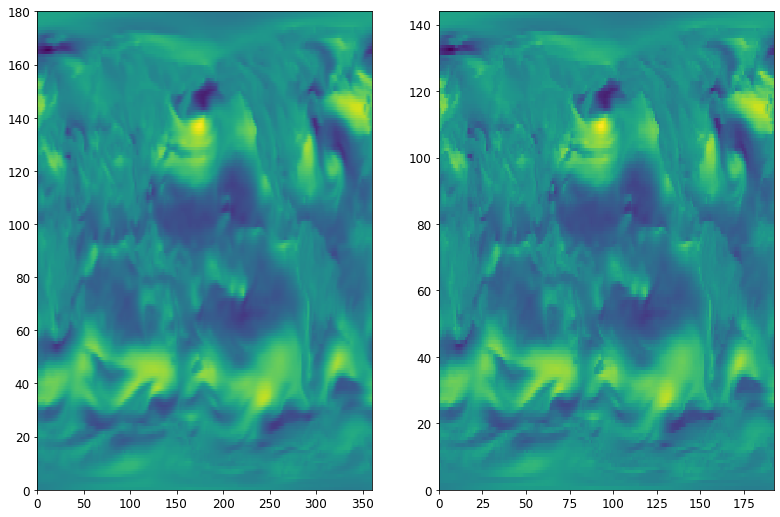

In [7]:
tdir = '/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/'
w = xr.open_dataset(f'{tdir}UKESM_1A_y1940m01_uwind10m_daily_rg.nc')
w2 = xr.open_dataset(f'{tdir}UKESM_1A_y1940m01_uwind10m_daily.nc')
fact = 1.1
fig, axs = plt.subplots(1,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].pcolormesh(w.uwind10m[0,:,:].values)
axs[1].pcolormesh(w2.uwind10m[0,:,:].values)

### daily resolution wind speed


In [7]:
scen = 'PI'
dir2 = '/gpfs/data/greenocean/software/products/MetOffice/u-aw310_pictrl/'
for y in range(1950,2101):
    print(y)
    yPI = y + 270
    print(yPI)
    wx = glob.glob(f'{dir2}/*wind*y{yPI}*')
    wx2 = np.sort(wx)#wx.sort()
    print(wx2)
    print()
    mons = ['01','02','03','04','05','06','07','08','09','10','11','12']
    for i in range(0,12):
        if f'm{mons[i]}' not in wx2[i]:
            print(f'problem in {fdir}, {mons[i]}')
        else:
            pass
        w = xr.open_dataset(wx2[i])
        savedir = '/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/'
        savestr = f'UKESM_{scen}_y{y}m{mons[i]}'
        print(savestr)
        w2 = w.uwind10m.groupby('time_counter.day').mean()
        w3 = w2.to_dataset()
        w3['day'] = np.arange(i*30+1,(i+1)*30+1,1)
        w3.attrs = {'made in': '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/UKESMwindsdaily.py'}
        w3.to_netcdf(f'{savedir}{savestr}_uwind10m_daily.nc')

        w4 = w.vwind10m.groupby('time_counter.day').mean()
        w5 = w4.to_dataset()
        w5['day'] = np.arange(i*30+1,(i+1)*30+1,1)
        w5.attrs = {'made in': '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/UKESMwindsdaily.py'}
        w5.to_netcdf(f'{savedir}{savestr}_vwind10m_daily.nc')

1950
2220
['/gpfs/data/greenocean/software/products/MetOffice/u-aw310_pictrl/aw310_wind_y2220m01.nc'
 '/gpfs/data/greenocean/software/products/MetOffice/u-aw310_pictrl/aw310_wind_y2220m02.nc'
 '/gpfs/data/greenocean/software/products/MetOffice/u-aw310_pictrl/aw310_wind_y2220m03.nc'
 '/gpfs/data/greenocean/software/products/MetOffice/u-aw310_pictrl/aw310_wind_y2220m04.nc'
 '/gpfs/data/greenocean/software/products/MetOffice/u-aw310_pictrl/aw310_wind_y2220m05.nc'
 '/gpfs/data/greenocean/software/products/MetOffice/u-aw310_pictrl/aw310_wind_y2220m06.nc'
 '/gpfs/data/greenocean/software/products/MetOffice/u-aw310_pictrl/aw310_wind_y2220m07.nc'
 '/gpfs/data/greenocean/software/products/MetOffice/u-aw310_pictrl/aw310_wind_y2220m08.nc'
 '/gpfs/data/greenocean/software/products/MetOffice/u-aw310_pictrl/aw310_wind_y2220m09.nc'
 '/gpfs/data/greenocean/software/products/MetOffice/u-aw310_pictrl/aw310_wind_y2220m10.nc'
 '/gpfs/data/greenocean/software/products/MetOffice/u-aw310_pictrl/aw310_wind_y2

KeyboardInterrupt: 

In [ ]:
/MetOffice/u-aw310_pictrl]$ vim cpwindSEP.sh
[mep22dku@login01 /gpfs/data/greenocean/software/products/MetOffice/u-aw310_pictrl
 
 
scp tjarniko@xfer1.jasmin.ac.uk://gws/nopw/j04/ukesm/bosley/ocean_forcing/fixed_ozone/pictrl/u-aw310_pictrl/aw310_wind_y2210m01.nc ./
 

In [8]:
import xarray as xr
import numpy as np

tdir = '/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/'

mons = ['01','02','03','04','05','06','07','08','09','10','11','12']
scens = ['1A','1B','2A','2B','3A','3B']

for s in scens:
    for y in range(1940,2101):
        for m in range(0,12):
            uwi = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m{mons[m]}_uwind10m_daily_rg.nc')
            vwi = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m{mons[m]}_vwind10m_daily_rg.nc')
            tnam = f'{tdir}UKESM_{s}_y{y}m{mons[m]}_wspd10m_daily_rg.nc'
            print(tnam)
            wspd = xr.ufuncs.sqrt(w.uwind10m**2 + w2.vwind10m**2)
            wspd.name = 'wspd10m'
            wspd = wspd.to_dataset()
            wspd.attrs = {'made in': '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/UKESMwspdfromuv.py'}
            wspd.to_netcdf(tnam)

/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1940m01_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1940m02_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1940m03_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1940m04_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1940m05_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1940m06_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1940m07_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1940m08_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/p

/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1945m09_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1945m10_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1945m11_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1945m12_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1946m01_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1946m02_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1946m03_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1946m04_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/p

/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1951m05_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1951m06_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1951m07_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1951m08_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1951m09_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1951m10_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1951m11_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1951m12_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/p

/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1957m01_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1957m02_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1957m03_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1957m04_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1957m05_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1957m06_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1957m07_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/UKESM_1A_y1957m08_wspd10m_daily_rg.nc
/gpfs/data/greenocean/software/p

KeyboardInterrupt: 

In [ ]:
import xarray as xr
import numpy as np

tdir = '/gpfs/data/greenocean/software/products/windsFromComponents/ERA5_v202303_rawdat/'

mons = ['01','02','03','04','05','06','07','08','09','10','11','12']
scens = ['1A']#,'1B','2A','2B','3A','3B']

for s in scens:
    for y in range(1940,1941):

        uwi = xr.open_dataset(f'{tdir}10m_u_component_of_wind_ERA5_{y}-daily_rg.nc')
        vwi = xr.open_dataset(f'{tdir}10m_u_component_of_wind_ERA5_{y}-daily_rg.nc')
        tnam = f'{tdir}10m_windspeed_ERA5_{y}-daily_rg.nc'
        print(tnam)
        wspd = xr.ufuncs.sqrt(w.uwind10m**2 + w2.vwind10m**2)
        wspd.name = 'wspd10m'
        wspd = wspd.to_dataset()
        wspd.attrs = {'made in': '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/ERAwspddaily.py'}
        wspd.to_netcdf(tnam)

In [ ]:
q = w.uwind10m[0,0,0].values
q2 = w2.vwind10m[0,0,0,].values

print(np.sqrt(q**2 + q2**2))

In [ ]:
wspd[0,0,0].

In [27]:
import xarray as xr
import numpy as np

tdir = '/gpfs/data/greenocean/software/products/windsFromComponents/UKESM_monthly_atdayres/'

mons = ['01','02','03','04','05','06','07','08','09','10','11','12']
scens = ['1A','1B','2A','2B','3A','3B','PI']


for s in scens:
    print(s)
    if s == 'PI':
        yst = 1950
    else:
        yst = 1940
    for y in range(yst,1941):

        Jan = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m01_wspd10m_daily_rg.nc')
        Feb = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m02_wspd10m_daily_rg.nc')
        Mar = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m03_wspd10m_daily_rg.nc')
        Apr = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m04_wspd10m_daily_rg.nc')  
        May = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m05_wspd10m_daily_rg.nc')
        Jun = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m06_wspd10m_daily_rg.nc')
        Jul = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m07_wspd10m_daily_rg.nc')
        Aug = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m08_wspd10m_daily_rg.nc')
        Sep = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m09_wspd10m_daily_rg.nc')
        Oct = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m10_wspd10m_daily_rg.nc')  
        Nov = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m11_wspd10m_daily_rg.nc')
        Dec = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m12_wspd10m_daily_rg.nc')
        
        DJF = np.zeros([90,180,360])
        DJF[0:30,:,:] = Dec.wspd10m.values
        DJF[30:60,:,:] = Jan.wspd10m.values
        DJF[60:90,:,:] = Feb.wspd10m.values
        
        MAM = np.zeros([90,180,360])
        MAM[0:30,:,:] = Mar.wspd10m.values
        MAM[30:60,:,:] = Apr.wspd10m.values
        MAM[60:90,:,:] = May.wspd10m.values
        
        JJA = np.zeros([90,180,360])
        JJA[0:30,:,:] = Jun.wspd10m.values
        JJA[30:60,:,:] = Jul.wspd10m.values
        JJA[60:90,:,:] = Aug.wspd10m.values
        
        SON = np.zeros([90,180,360])
        SON[0:30,:,:] = Sep.wspd10m.values
        SON[30:60,:,:] = Oct.wspd10m.values
        SON[60:90,:,:] = Nov.wspd10m.values
        
        seasns = np.zeros([4,180,360])
        seasns[0,:,:] = np.nanmean(DJF, axis = 0)
        seasns[1,:,:] = np.nanmean(MAM, axis = 0)
        seasns[2,:,:] = np.nanmean(JJA, axis = 0)
        seasns[3,:,:] = np.nanmean(SON, axis = 0)
        
        times = pd.to_datetime([f"{y}-01-15", f"{y}-04-15", f"{y}-07-15", f"{y}-10-15"])
        
        savenam = (f'{tdir}UKESM_{s}_y{y}_wspd10m_seas_rg.nc')
        data_vars = {'wspd10m':(['time_counter', 'lat', 'lon'], seasns,
        {'units': 'm/s',
        'long_name':'10m windspeed regridded'}),
        }
        # define coordinates
        coords = {'time_counter': (['time_counter'], times),
                
        'lon': (['lon'], Jan.lon.values),
        'lat': (['lat'], Jan.lat.values),
        }
        # define global attributes
        attrs = {'made in':'/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/UKESM-seas-wspd.py',

        }
        ds = xr.Dataset(data_vars=data_vars,
        coords=coords,
        attrs=attrs)
        
        ds.to_netcdf(savenam)        

1A


In [36]:

for y in range(1940,2023):
    
    tdir = '/gpfs/data/greenocean/software/products/windsFromComponents/ERA5_v202303_rawdat/'
    tfil = f'10m_windspeed_ERA5_{y}-daily_rg.nc'
    w = xr.open_dataset(f'{tdir}{tfil}')
    tvar = w.wspd10m.groupby('time.season').mean()

    times = pd.to_datetime([f"{y}-01-15", f"{y}-04-15", f"{y}-07-15", f"{y}-10-15"])

    savenam = (f'{tdir}ERA5_y{y}_wspd10m_seas_rg.nc')
    data_vars = {'wspd10m':(['time_counter', 'lat', 'lon'], tvar.values,
    {'units': 'm/s',
    'long_name':'10m windspeed regridded'}),
    }
    # define coordinates
    coords = {'time_counter': (['time_counter'], times),

    'lon': (['lon'], Jan.lon.values),
    'lat': (['lat'], Jan.lat.values),
             }
    
    attrs = {'made in':'/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/ERA5-seas-wspd.py',

    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    
    ds.to_netcdf(savenam)  

In [37]:
ds

<xarray.Dataset>
Dimensions:       (lat: 180, lon: 360, time_counter: 4)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1940-01-15 ... 1940-10-15
  * lon           (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat           (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    wspd10m       (time_counter, lat, lon) float32 4.4935937 ... 4.671403
Attributes:
    made in:  /gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/E...